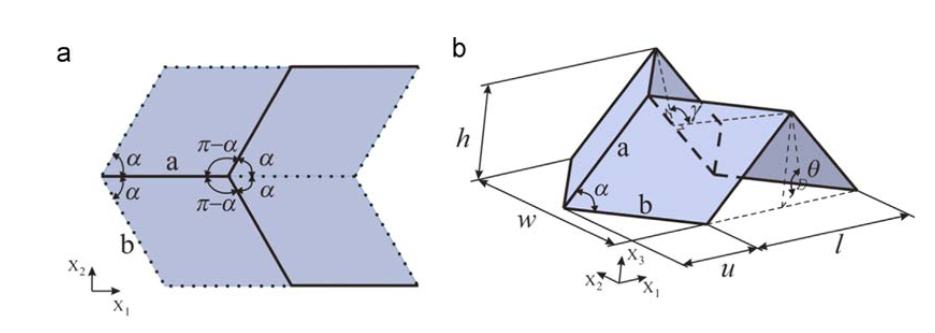

Medidas del módulo de Miura

Medidas del ángulo theta
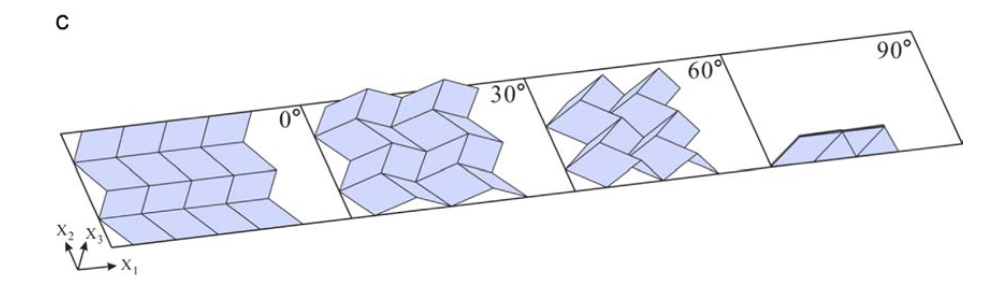

Medidas del ángulo alpha
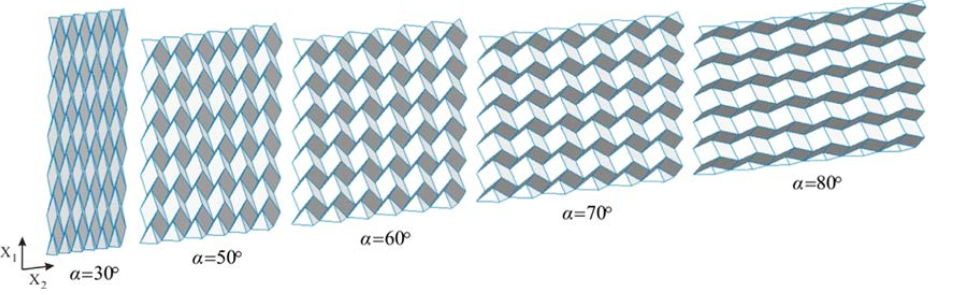

Para la optimización se maximizará el área total desplegada, que corresponde a: 
$$[2na+b*sin(\pi/2 - \alpha)]*2nb*sin(\alpha)$$

Al menos en esta primera iteración se considerará cuadrada.
En este caso entonces, igualando ambos largos se obtiene la expresión:
$$2na+b*sin(\pi/2 - \alpha)=2nb*sin(\alpha)$$

$n$ es el número de módulos, que tiene la forma: $m/2$, con $m$ un entero.

Se debe respetar la restricción para cuando la vela esté plegada dentro del cubesat, en donde no puede exceder los 100 mm de lado:
$$100>= b*\frac{cos(\theta)*tan(\alpha)}{\sqrt{1+cos^2(\theta)*tan^2(\alpha)}}+am\sqrt{1-sen^2(\theta)sen^2(\alpha)}+\frac{b*cos(\alpha)}{\sqrt{1-sen^2(\theta)sen^2(\alpha)}}$$

In [8]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def area(model, a, b, m, angulo1):
    angulo1 = np.radians(angulo1)
    
    # Definir términos de la expresión cuadrática
    term1 = model.addVar(vtype=GRB.CONTINUOUS, name="term1")
    term2 = model.addVar(vtype=GRB.CONTINUOUS, name="term2")
    
    # Añadir restricciones para calcular los términos
    model.addConstr(term1 == m * a + b * np.sin(np.pi / 2 - angulo1))
    model.addConstr(term2 == m * b * np.sin(angulo1))
    
    # Crear una expresión cuadrática para el área
    area_expr = term1 * term2
    
    # Devolver la expresión cuadrática
    return area_expr


def perimetro(model, a, b, m, angulo1, angulo2):
    angulo1 = np.radians(angulo1)
    angulo2 = np.radians(angulo2)
    
    # Definir términos de la expresión lineal
    term1 = model.addVar(vtype=GRB.CONTINUOUS, name="term1")
    term2 = model.addVar(vtype=GRB.CONTINUOUS, name="term2")
    term3 = model.addVar(vtype=GRB.CONTINUOUS, name="term3")
    
    # Añadir restricciones para calcular los términos
    model.addConstr(term1 == b * (np.cos(angulo1) * np.tan(angulo2)) / np.sqrt(1 + np.cos(angulo1)**2 * np.tan(angulo2)**2))
    model.addConstr(term2 == a * m * np.sqrt(1 - np.sin(angulo1)**2 * np.sin(angulo2)**2))
    model.addConstr(term3 == b * np.cos(angulo2) / np.sqrt(1 - np.sin(angulo1)**2 * np.sin(angulo2)**2))
    
    # Crear una expresión lineal para el perímetro
    perimeter_expr = term1 + term2 + term3
    
    # Devolver la expresión lineal
    return perimeter_expr


# Crear un nuevo modelo de Gurobi
model = gp.Model()

# Definir las variables de decisión
a = model.addVar(lb=0, ub=100, name="a") 
b = model.addVar(lb=0, ub=100, name="b")
m = model.addVar(vtype=GRB.INTEGER, lb=2, name="m")

# Añadir restricciones
model.addConstr(a >= 0, name="a_positive")
model.addConstr(b >= 0, name="b_positive")
model.addConstr(m >= 2, name="minimum_m")

# Añadir restricciones de relación entre a y b
model.addConstr(a >= b / 3, name="a_at_least_one_third_of_b")
model.addConstr(a <= 3 * b, name="a_at_most_three_times_b")
model.addConstr(a <= 100, name="a_at_most_100")
model.addConstr(b <= 100, name="b_at_most_100")
model.addConstr(m <=35, name="m_at_most_100")
# Definir ángulos
theta = 86  # Ángulo 1 en grados
alpha = 70  # Ángulo 2 en grados

# Añadir restricción del perímetro
model.addConstr(perimetro(model, a, b, m, theta, alpha) <= 250, name="perimeter_constraint")


# Establecer la función objetivo
model.setObjective(area(model, a, b, m, alpha), GRB.MAXIMIZE)

# Optimizar el modelo
model.optimize()

# Imprimir la solución óptima
if model.status == GRB.OPTIMAL:
    print("Solución óptima encontrada:")
    print("a =", a.x, "b =", b.x, "m =", m.x)
else:
    print("No se encontró una solución óptima.")

# Evaluar el valor de la función objetivo
print("Valor de la función objetivo:", model.objVal)

#generar puntos para graficar
a_vals=np.linspace(0,100,100)
b_vals=np.linspace(0,100,100)
m_vals=np.linspace(2,35,34)

A,B,M=np.meshgrid(a_vals,b_vals,m_vals)

area_values=area(A,B,M,alpha).reshape(A.shape)

# Graficar el espacio de soluciones
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(A[:,:,0], B[:,:,0], area_values[:,:,0], cmap='viridis')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('Área')
ax.set_title('Espacio de Soluciones y Función de Área')
plt.show()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 11 rows, 8 columns and 17 nonzeros
Model fingerprint: 0x69dfffa8
Model has 1 quadratic objective term
Model has 3 quadratic constraints
Variable types: 7 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-01, 3e+00]
  QMatrix range    [3e-01, 1e+00]
  QLMatrix range   [3e-01, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [2e+00, 1e+02]
  RHS range        [2e+00, 3e+02]
Found heuristic solution: objective -0.0000000
Presolve removed 7 rows and 2 columns
Presolve time: 0.00s
Presolved: 14 rows, 7 columns, 33 nonzeros
Presolved model has 3 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 6 continuous, 1 integer (0 binary)
Foun

TypeError: area() missing 1 required positional argument: 'angulo1'

In [9]:
model.display()

Maximize
  0.0 + [ term1 * term2 ]
Subject To
  a_positive: a >= 0
  b_positive: b >= 0
  minimum_m: m >= 2
  a_at_least_one_third_of_b: a + -0.3333333333333333 b >= 0
  a_at_most_three_times_b: a + -3.0 b <= 0
  a_at_most_100: a <= 100
  b_at_most_100: b <= 100
  m_at_most_100: m <= 35
  R8: -0.18822856324777493 b + term1 = 0
  R9: -0.9821252506567971 b + term3 = 0
  perimeter_constraint: term1 + term2 + term3 <= 250
  : term2 + [ -0.3482449342351625 a * m ] = 0
  : -0.34202014332566877 b + term1 + [ -1.0 a * m ] = 0
  : term2 + [ -0.9396926207859083 b * m ] = 0
Bounds
  0 <= a <= 100
  0 <= b <= 100
  2 <= m <= inf
General Integers
  ['m']


C:\Users\Karen\AppData\Local\Temp\ipykernel_16440\259237463.py:1: DeprecationWarning: Model.display() is deprecated
  model.display()


In [88]:
def calcular_lado(x):
    #x in mm2 to cm2
    x = x / 100
    lado= np.sqrt(x)
    print("Lado: ", lado)

calcular_lado(model.objVal)

Lado:  94.93938654241023
